## Natural Language Visualization With Scattertext
## Jason S. Kessler @jasonkessler
### Global AI Conference 2018, Seattle, WA. April 27, 2018.

The Github repository for talk is at [https://github.com/JasonKessler/GlobalAI2018](https://github.com/JasonKessler/GlobalAI2018). 

Visualizations were made using [Scattertext](https://github.com/JasonKessler/scattertext).

Please cite as: 
Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017.

In [4]:
import pandas as pd
import numpy as np
import scattertext as st
import spacy
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline 

In [5]:
assert st.__version__ >= '0.0.2.25'

### The data
 
Dataset consists of reviews of movies and plot descriptions.  Plot descriptions are guaranteed to be from a movie which was reviewed. 

Data set is from http://www.cs.cornell.edu/people/pabo/movie-review-data/

References:
* Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan, Thumbs up? Sentiment Classification using Machine Learning Techniques, Proceedings of EMNLP 2002.

* Bo Pang and Lillian Lee, A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, Proceedings of ACL 2004.

In [6]:
rdf = st.SampleCorpora.RottenTomatoes.get_data()
rdf['category_name'] = rdf['category'].apply(lambda x: {'plot': 'Plot', 'rotten': 'Negative', 'fresh': 'Positive'}[x])
print(rdf.category_name.value_counts())
rdf[['text', 'movie_name', 'category_name']].head()

Positive    2455
Negative    2411
Plot         156
Name: category_name, dtype: int64


,text,movie_name,category_name
0,"A senior at an elite college (Katie Holmes), a...",abandon,Plot
1,Will Lightman is a hip Londoner who one day re...,about_a_boy,Plot
2,Warren Schmidt (Nicholson) is forced to deal w...,about_schmidt,Plot
3,An account of screenwriter Charlie Kaufman's (...,adaptation,Plot
4,Ali G unwittingly becomes a pawn in the evil C...,ali_g_indahouse,Plot


In [7]:
corpus = (st.CorpusFromPandas(rdf, 
                              category_col='category_name', 
                              text_col='text',
                              nlp = st.whitespace_nlp_with_sentences)
          .build())
corpus.get_term_freq_df().to_csv('term_freqs.csv')
unigram_corpus = corpus.get_unigram_corpus()

### Let's visualize the corpus using Scattertext

The x-axis indicates the rank of a word or bigram in the set of positive reviews, and the y-axis negative reviews.

Ranks are determined using "dense" ranking, meaning the most frequent terms, regardless of ties, are given rank 1, the next most frequent terms, regardless of ties, are given rank 2, etc.

It appears that terms more associated with a class are a further distance from the diagonal line between the lower-left and upper-right corners.  Terms are colored according to this distance.  We'll return to this in a bit.

Scattertext selectively labels points in such a way as to prevent labels from overlapping other elements of the graph. Mouse-over points and term labels for a preview, and click for a key-word in context view.

References:
* Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017.

In [5]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    metadata=rdf['movie_name'],
    term_scorer=st.RankDifference(),
    transform=st.Scalers.percentile_dense
)
file_name = 'rotten_fresh_stdense.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### We view can see more terms through breaking ties in ranking alphabetically.
Lower frequency terms are more prominent in this view, and more terms can be labeled.

In [6]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    metadata=rdf['movie_name'],
    term_scorer=st.RankDifference(),
)
file_name = 'rotten_fresh_st.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

## Scaled F-Score
### Associatied terms have a *relatively* high category-specific precision and category-specific term frequency (i.e., % of terms in category are term)
### Take the harmonic mean of precision and frequency (both have to be high)
### We will make two adjustments to this method in order to come up with the final formulation of Scaled F-Score

Given a word $w_i \in W$ and a category $c_j \in C$, define the precision of the word $w_i$ wrt to a category as:
$$ \mbox{prec}(i,j) = \frac{\#(w_i, c_j)}{\sum_{c \in C} \#(w_i, c)}. $$

The function $\#(w_i, c_j)$ represents either the number of times $w_i$ occurs in a document labeled with the category $c_j$ or the number of documents labeled $c_j$ which contain $w_i$.

Similarly, define the frequency a word occurs in the category as:

$$ \mbox{freq}(i, j) = \frac{\#(w_i, c_j)}{\sum_{w \in W} \#(w, c_j)}. $$

The harmonic mean of these two values of these two values is defined as:

$$ \mathcal{H}_\beta(i,j) = (1 + \beta^2) \frac{\mbox{prec}(i,j) \cdot \mbox{freq}(i,j)}{\beta^2 \cdot \mbox{prec}(i,j) + \mbox{freq}(i,j)}. $$

$\beta \in \mathcal{R}^+$ is a scaling factor where frequency is favored if $\beta < 1$, precision if $\beta > 1$, and both are equally weighted if $\beta = 1$. F-Score is equivalent to the harmonic mean where $\beta = 1$.

In [8]:
from scipy.stats import hmean

term_freq_df = corpus.get_unigram_corpus().get_term_freq_df()[['Positive freq', 'Negative freq']]
term_freq_df = term_freq_df[term_freq_df.sum(axis=1) > 0]

term_freq_df['pos_precision'] = (term_freq_df['Positive freq'] * 1./
                                 (term_freq_df['Positive freq'] + term_freq_df['Negative freq']))

term_freq_df['pos_freq_pct'] = (term_freq_df['Positive freq'] * 1.
                                /term_freq_df['Positive freq'].sum())

term_freq_df['pos_hmean'] = (term_freq_df
                             .apply(lambda x: (hmean([x['pos_precision'], x['pos_freq_pct']])
                                               if x['pos_precision'] > 0 and x['pos_freq_pct'] > 0 
                                               else 0), axis=1))
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,Positive freq,Negative freq,pos_precision,pos_freq_pct,pos_hmean
term,,,,,
the,2346,2288,0.506258,0.048037,0.087748
a,1775,1613,0.523908,0.036345,0.067975
and,1637,1179,0.581321,0.033520,0.063385
of,1480,1235,0.545120,0.030305,0.057418
to,942,1010,0.482582,0.019289,0.037095
it,826,801,0.507683,0.016913,0.032736
is,818,726,0.529793,0.016750,0.032473
s,808,749,0.518947,0.016545,0.032067
in,676,622,0.520801,0.013842,0.026967


In [9]:
term_freq_df.pos_freq_pct.describe()

count    12032.000000
mean         0.000083
std          0.000826
min          0.000000
25%          0.000000
50%          0.000020
75%          0.000041
max          0.048037
Name: pos_freq_pct, dtype: float64

In [10]:
term_freq_df.pos_precision.describe()

count    12032.000000
mean         0.506651
std          0.418623
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: pos_precision, dtype: float64

In [77]:
# The plot looks a bit better if you Anscombe transform the data, but it doesn't make a difference in SFS
#freq = 2*(np.sqrt(term_freq_df.pos_freq_pct.values)+3/8)

freq = term_freq_df.pos_freq_pct.values
prec = term_freq_df.pos_precision.values
html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Portion of words used in positive reviews',
    original_x = freq,
    x_coords = (freq - freq.min())/freq.max(),
    x_axis_values = [int(freq.min()*1000)/1000., 
                     int(freq.max() * 1000)/1000.],
    
    y_label = 'Portion of documents containing word that are positive',    
    original_y = prec,
    y_coords = (prec - prec.min())/prec.max(),
    y_axis_values = [int(prec.min() * 1000)/1000., 
                     int((prec.max()/2.)*1000)/1000., 
                     int(prec.max() * 1000)/1000.],
    scores = term_freq_df.pos_hmean.values,
    
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'not_normed_freq_prec.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

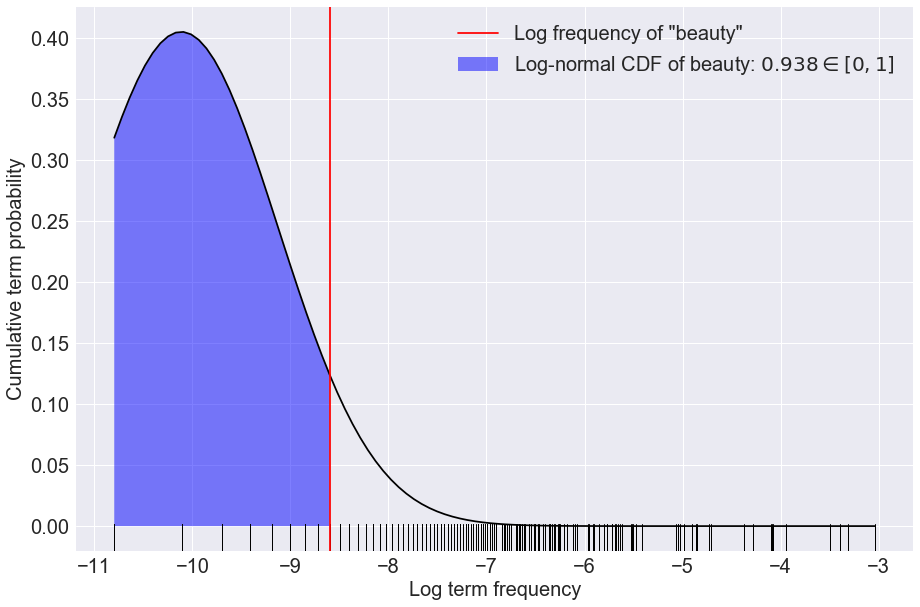

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(15,10))
freqs = term_freq_df.pos_freq_pct[term_freq_df.pos_freq_pct > 0]
log_freqs = np.log(freqs)

sns.distplot(log_freqs[:1000], kde=False, rug=True, hist=False, rug_kws={"color": "k"})

x = np.linspace(log_freqs.min(), 
                log_freqs.max(), 
                100)
frozen_norm = norm(log_freqs.mean(), log_freqs.std())
y = frozen_norm.pdf(x)
plt.plot(x, y ,color='k')
term = 'beauty'
word_freq = log_freqs.loc[term]
term_cdf = frozen_norm.cdf(word_freq)
plt.axvline(x=word_freq, color='red', label='Log frequency of "'+term+'"')
plt.fill_between(x[x < word_freq], 
                 y[x < word_freq], y[x < word_freq] * 0, 
                 facecolor='blue', 
                 alpha=0.5,
                 label="Log-normal CDF of %s: $%0.3f \in [0,1]$" % (term, term_cdf) )
ax.set_xlabel('Log term frequency')
ax.set_ylabel('Cumulative term probability')
plt.legend()
for item in ([ax.title,  ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(20)
plt.rc('legend', fontsize=20)     
plt.show()

## Problem: harmonic means are dominated by the precision
### Take the normal CDF of precision and frequency percentage scores, which will fall between 0 and 1, which scales and standardizes both scores.

Define the the Normal CDF as:

$$ \Phi(z) = \int_{-\infty}^z \mathcal{N}(x; \mu, \sigma^2)\ \mathrm{d}x.$$

Where $ \mathcal{N} $ is the PDF of the Normal distribution, $\mu$ is the mean, and $\sigma^2$ is the variance.

$\Phi$ is used to scale and standardize the precisions and frequencies, and place them on the same scale $[0,1]$.

Now we can define Scaled F-Score as the harmonic mean of the Normal CDF transformed frequency and precision:

$$ \mbox{S-CAT}_{\beta}(i, j) = \mathcal{H}_{\beta}(\Phi(\mbox{prec}(i, j)), \Phi(\mbox{freq}(i, j))).$$

$\mu$ and $\sigma^2$ are defined separately as the mean and variance of precision and frequency.

A $\beta$ of 2 is recommended and is the default value in Scattertext.

Note that any function with the range of $[0,1]$ (this includes the identity function) may be used in place of $\Phi$.  Also, when the precision is very small (e.g., of a tiny minority class) normalization may be foregone.

In [78]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std ())

term_freq_df['pos_precision_normcdf'] = normcdf(term_freq_df.pos_precision)

term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df.pos_freq_pct.values)

term_freq_df['pos_scaled_f_score'] = hmean([term_freq_df['pos_precision_normcdf'], term_freq_df['pos_freq_pct_normcdf']])

term_freq_df.sort_values(by='pos_scaled_f_score', ascending=False).iloc[:10]


,Positive freq,Negative freq,pos_precision,pos_freq_pct,pos_hmean,pos_precision_normcdf,pos_freq_pct_normcdf,pos_scaled_f_score
term,,,,,,,,
best,108,36,0.750000,0.002211,0.004410,0.719483,0.995008,0.835107
entertaining,58,13,0.816901,0.001188,0.002372,0.770690,0.909394,0.834316
fun,73,26,0.737374,0.001495,0.002983,0.709233,0.956259,0.814427
heart,45,11,0.803571,0.000921,0.001841,0.760924,0.844900,0.800716
great,61,23,0.726190,0.001249,0.002494,0.700011,0.920936,0.795418
still,63,26,0.707865,0.001290,0.002575,0.684620,0.927988,0.787940
our,42,11,0.792453,0.000860,0.001718,0.752608,0.826505,0.787827
performance,53,19,0.736111,0.001085,0.002167,0.708199,0.887454,0.787758
love,61,25,0.709302,0.001249,0.002494,0.685839,0.920936,0.786188


In [79]:
term_freq_df.sort_values(by='pos_scaled_f_score', ascending=True).iloc[:10]

,Positive freq,Negative freq,pos_precision,pos_freq_pct,pos_hmean,pos_precision_normcdf,pos_freq_pct_normcdf,pos_scaled_f_score
term,,,,,,,,
brawny,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
derivativeness,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
blatant,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
jams,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
staleness,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
luck,0,2,0.0,0.0,0.0,0.113086,0.459931,0.181537
screenplays,0,2,0.0,0.0,0.0,0.113086,0.459931,0.181537
tripe,0,1,0.0,0.0,0.0,0.113086,0.459931,0.181537
lackluster,0,6,0.0,0.0,0.0,0.113086,0.459931,0.181537


In [81]:
freq = term_freq_df.pos_freq_pct_normcdf.values
prec = term_freq_df.pos_precision_normcdf.values
html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Portion of words used in positive reviews (norm-cdf)',
    original_x = freq,
    x_coords = (freq - freq.min())/freq.max(),
    x_axis_values = [int(freq.min()*1000)/1000., 
                     int(freq.max() * 1000)/1000.],
    
    y_label = 'documents containing word that are positive (norm-cdf)',    
    original_y = prec,
    y_coords = (prec - prec.min())/prec.max(),
    y_axis_values = [int(prec.min() * 1000)/1000., 
                     int((prec.max()/2.)*1000)/1000., 
                     int(prec.max() * 1000)/1000.],
    scores = term_freq_df.pos_scaled_f_score.values,
    
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'normed_freq_prec.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

## A second problem: low scores are low-frequency brittle terms.
## Make the approach fair to negative scoring terms
### Solution: compute SFS of negative class. If that score has a higher magnitude than the positive SFS, keep that, but as a negative score.

Define the Scaled F-Score for category $j$ as
$$ \mbox{S-CAT}^{j} =  \mbox{S-CAT}_{\beta}(i, j). $$

Define a class $\neg j$ which includes all categories other than $j$.

and the Scaled F-Score for all other categories as
$$ \mbox{S-CAT}^{\neg j} = \mbox{S-CAT}_{\beta}(i, \neg j). $$

Let the corrected version of Scaled F-Score be:

$$\mathcal{S}_{\beta} = 2 \cdot \big(-0.5 + \begin{cases}
      \mbox{S-CAT}^{j} & \text{if}\ \mbox{S-CAT}^{j} > \mbox{S-CAT}^{\neg j}, \\
      1 - \mbox{S-CAT}^{\neg j} & \text{if}\ \mbox{S-CAT}^{j} < \mbox{S-CAT}^{\neg j}, \\
      0 & \text{otherwise}.
    \end{cases} \big).$$
    
Note that the range of $\mathcal{S}$ is now $[-1, 1]$, where $\mathcal{S} < 0$ indicates a term less associated with the category is question than average, and a positive score being more associated.

In [83]:
term_freq_df['neg_precision_normcdf'] = normcdf((term_freq_df['Negative freq'] * 1./
                                 (term_freq_df['Negative freq'] + term_freq_df['Positive freq'])))

term_freq_df['neg_freq_pct_normcdf'] = normcdf((term_freq_df['Negative freq'] * 1.
                                /term_freq_df['Negative freq'].sum()))

term_freq_df['neg_scaled_f_score'] = hmean([term_freq_df['neg_precision_normcdf'],  term_freq_df['neg_freq_pct_normcdf']])

term_freq_df['scaled_f_score'] = 0
term_freq_df.loc[term_freq_df['pos_scaled_f_score'] > term_freq_df['neg_scaled_f_score'], 
                 'scaled_f_score'] = term_freq_df['pos_scaled_f_score']
term_freq_df.loc[term_freq_df['pos_scaled_f_score'] < term_freq_df['neg_scaled_f_score'], 
                 'scaled_f_score'] = 1-term_freq_df['neg_scaled_f_score']
term_freq_df['scaled_f_score'] = 2 * (term_freq_df['scaled_f_score'] - 0.5)
term_freq_df.sort_values(by='scaled_f_score', ascending=False).iloc[:10]

,Positive freq,Negative freq,pos_precision,pos_freq_pct,pos_hmean,pos_precision_normcdf,pos_freq_pct_normcdf,pos_scaled_f_score,neg_precision_normcdf,neg_freq_pct_normcdf,neg_scaled_f_score,scaled_f_score
term,,,,,,,,,,,,
best,108,36,0.750000,0.002211,0.004410,0.719483,0.995008,0.835107,0.280517,0.805491,0.416118,0.670214
entertaining,58,13,0.816901,0.001188,0.002372,0.770690,0.909394,0.834316,0.229310,0.596336,0.331246,0.668633
fun,73,26,0.737374,0.001495,0.002983,0.709233,0.956259,0.814427,0.290767,0.723380,0.414801,0.628854
heart,45,11,0.803571,0.000921,0.001841,0.760924,0.844900,0.800716,0.239076,0.575415,0.337801,0.601433
great,61,23,0.726190,0.001249,0.002494,0.700011,0.920936,0.795418,0.299989,0.695802,0.419230,0.590836
still,63,26,0.707865,0.001290,0.002575,0.684620,0.927988,0.787940,0.315380,0.723380,0.439254,0.575880
our,42,11,0.792453,0.000860,0.001718,0.752608,0.826505,0.787827,0.247392,0.575415,0.346019,0.575654
performance,53,19,0.736111,0.001085,0.002167,0.708199,0.887454,0.787758,0.291801,0.657250,0.404164,0.575515
love,61,25,0.709302,0.001249,0.002494,0.685839,0.920936,0.786188,0.314161,0.714324,0.436395,0.572376


In [84]:
term_freq_df.sort_values(by='scaled_f_score', ascending=True).iloc[:10]

,Positive freq,Negative freq,pos_precision,pos_freq_pct,pos_hmean,pos_precision_normcdf,pos_freq_pct_normcdf,pos_scaled_f_score,neg_precision_normcdf,neg_freq_pct_normcdf,neg_scaled_f_score,scaled_f_score
term,,,,,,,,,,,,
bad,17,105,0.139344,0.000348,0.000694,0.190130,0.625807,0.291652,0.809870,0.996676,0.893614,-0.787229
too,42,147,0.222222,0.000860,0.001713,0.248430,0.826505,0.382030,0.751570,0.999939,0.858145,-0.716289
were,14,50,0.218750,0.000287,0.000573,0.245811,0.597317,0.348291,0.754189,0.892009,0.817330,-0.634660
only,43,100,0.300699,0.000880,0.001756,0.311369,0.832785,0.453267,0.688631,0.995056,0.813959,-0.627919
would,33,72,0.314286,0.000676,0.001349,0.322931,0.763424,0.453872,0.677069,0.966222,0.796206,-0.592412
no,65,130,0.333333,0.001331,0.002651,0.339430,0.934547,0.497990,0.660570,0.999644,0.795481,-0.590963
just,76,145,0.343891,0.001556,0.003098,0.348713,0.962723,0.511979,0.651287,0.999924,0.788800,-0.577600
video,11,39,0.220000,0.000225,0.000450,0.246752,0.568300,0.344099,0.753248,0.826890,0.788353,-0.576706
script,25,57,0.304878,0.000512,0.001022,0.314906,0.698142,0.434035,0.685094,0.922954,0.786432,-0.572864


In [86]:
is_pos = term_freq_df.pos_scaled_f_score > term_freq_df.neg_scaled_f_score
freq = term_freq_df.pos_freq_pct_normcdf*is_pos - term_freq_df.neg_freq_pct_normcdf*~is_pos
prec = term_freq_df.pos_precision_normcdf*is_pos - term_freq_df.neg_precision_normcdf*~is_pos
def scale(ar): 
    return (ar - ar.min())/(ar.max() - ar.min())
def close_gap(ar): 
    ar[ar > 0] -= ar[ar > 0].min()
    ar[ar < 0] -= ar[ar < 0].max()
    return ar

html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Frequency',
    original_x = freq,
    x_coords = scale(close_gap(freq)),
    x_axis_labels = ['Frequent in Neg', 
                     'Not Frequent', 
                     'Frequent in Pos'],
    
    y_label = 'Precision',    
    original_y = prec,
    y_coords = scale(close_gap(prec)),
    y_axis_labels = ['Neg Precise', 
                     'Imprecise', 
                     'Pos Precise'],
    
    
    scores = (term_freq_df.scaled_f_score.values + 1)/2,
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'sfs_explain.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

In [90]:
html = st.produce_frequency_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=st.ScaledFScorePresets(beta=1, one_to_neg_one=True),
    metadata = rdf['movie_name'],
    grey_threshold=0
)
file_name = 'freq_sfs.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)